In [2]:
import os
import sys
import re
import shutil
import time
import pickle
from collections import defaultdict
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from read_json_files import fetch_data
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [3]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    #rolmean = pd.rolling_mean(timeseries, window=12)
    rolmean = timeseries.rolling(12).mean()
    #rolstd = pd.rolling_std(timeseries, window=12)
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [4]:
df = fetch_data('data\cs-train')

reading files from directory: data\cs-train


In [5]:
print("*** shape ***")
print(df.shape)
print("*** info ***")
print(df.info())

*** shape ***
(815011, 10)
*** info ***
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 815011 entries, 0 to 815010
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   country       815011 non-null  object        
 1   customer_id   625249 non-null  float64       
 2   day           815011 non-null  int64         
 3   invoice       815011 non-null  object        
 4   month         815011 non-null  int64         
 5   price         815011 non-null  float64       
 6   stream_id     815011 non-null  object        
 7   times_viewed  815011 non-null  int64         
 8   year          815011 non-null  int64         
 9   invoice_date  815011 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 62.2+ MB
None


In [7]:
df.head()

,country,customer_id,day,invoice,month,price,stream_id,times_viewed,year,invoice_date
0,United Kingdom,13085.0,28,489434,11,6.95,85048,12,2017,2017-11-28
1,United Kingdom,13085.0,28,489434,11,6.75,79323W,12,2017,2017-11-28
2,United Kingdom,13085.0,28,489434,11,2.10,22041,21,2017,2017-11-28
3,United Kingdom,13085.0,28,489434,11,1.25,21232,5,2017,2017-11-28
4,United Kingdom,13085.0,28,489434,11,1.65,22064,17,2017,2017-11-28


In [6]:
df.isnull().sum(axis="rows")

country              0
customer_id     189762
day                  0
invoice              0
month                0
price                0
stream_id            0
times_viewed         0
year                 0
invoice_date         0
dtype: int64

In [8]:
df.describe()

,customer_id,day,month,price,times_viewed,year
count,625249.000000,815011.000000,815011.000000,815011.000000,815011.000000,815011.000000
mean,15333.415068,15.064819,6.592718,4.802631,5.231106,2018.247654
std,1698.360788,8.788845,3.598781,135.058707,5.109982,0.545261
min,12346.000000,1.000000,1.000000,-53594.360000,0.000000,2017.000000
25%,13956.000000,7.000000,3.000000,1.250000,1.000000,2018.000000
50%,15279.000000,15.000000,6.000000,2.100000,3.000000,2018.000000
75%,16813.000000,23.000000,10.000000,4.210000,8.000000,2019.000000
max,18287.000000,31.000000,12.000000,38970.000000,24.000000,2019.000000


### For now I will fill with 99999 customer_id which value is NaN

In [9]:
df.loc[df["customer_id"].isnull(),"customer_id"] = 99999

In [10]:
ts = df.sort_values(by="invoice_date")
ts = ts.groupby("invoice_date")["price"].sum()

### Verificar se ts é estacionária

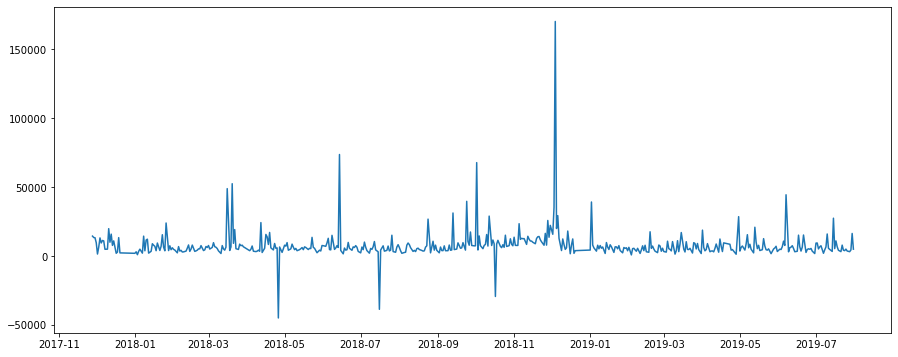

In [11]:
plt.plot(ts)

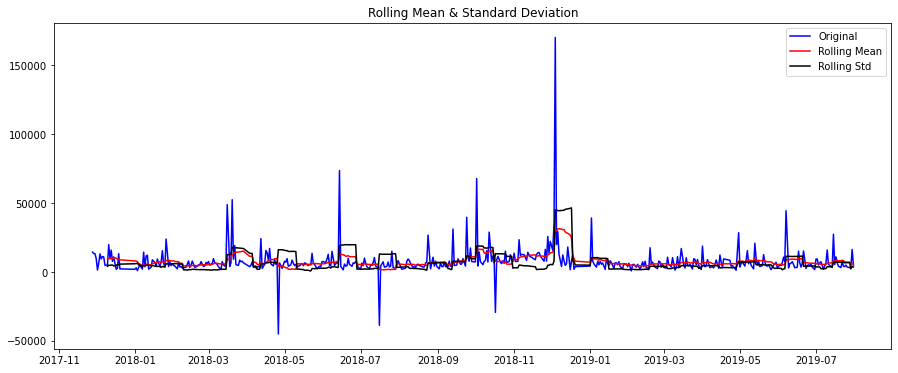

Results of Dickey-Fuller Test:
Test Statistic                -1.017756e+01
p-value                        6.828860e-18
#Lags Used                     2.000000e+00
Number of Observations Used    4.920000e+02
Critical Value (1%)           -3.443711e+00
Critical Value (5%)           -2.867432e+00
Critical Value (10%)          -2.569908e+00
dtype: float64


In [12]:
test_stationarity(ts)

### Fazendo o forecast

In [44]:
lag_acf = acf(ts, nlags=14)
lag_pacf = pacf(ts, nlags=14, method='ols')

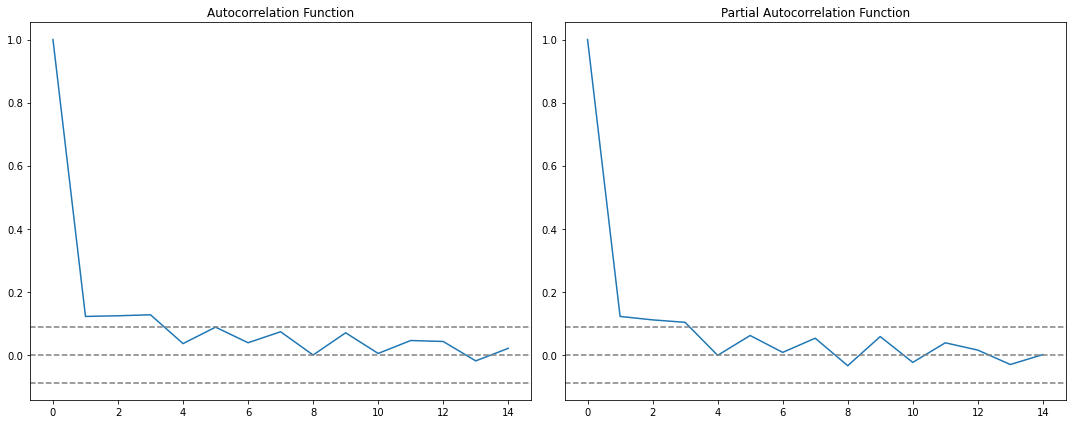

In [45]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF: 
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray') 
plt.title('Partial Autocorrelation Function') 
plt.tight_layout()

### Modelo combinado

C:\Users\AlexandredeBarrosRod\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\AlexandredeBarrosRod\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Text(0.5, 1.0, 'RSS: 55002680626.9868')

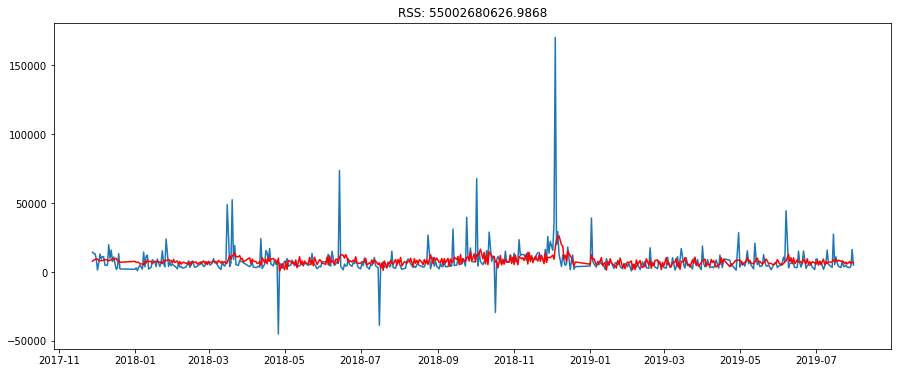

In [16]:
model = ARIMA(ts, order=(8, 0, 8)) 
results_ARIMA = model.fit(disp=2) 
plt.plot(ts) 
plt.plot(results_ARIMA.fittedvalues, color='red') 
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts)**2))

### Predição

Text(0.5, 1.0, 'RSS: 55002680626.9868')

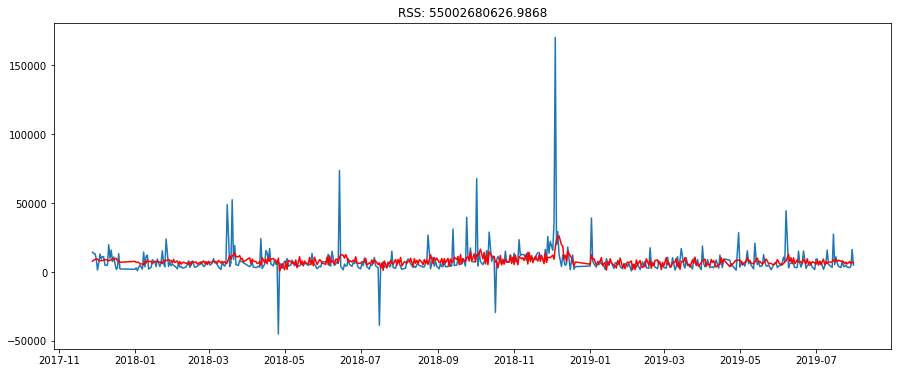

In [17]:
predicted = results_ARIMA.predict(start=None, end=None, exog=None, typ='linear', dynamic=False)
plt.plot(ts)
plt.plot(predicted, color='red') 
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts)**2))

C:\Users\AlexandredeBarrosRod\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\AlexandredeBarrosRod\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\AlexandredeBarrosRod\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


Text(0.5, 1.0, 'RSS: 55002680626.9868')

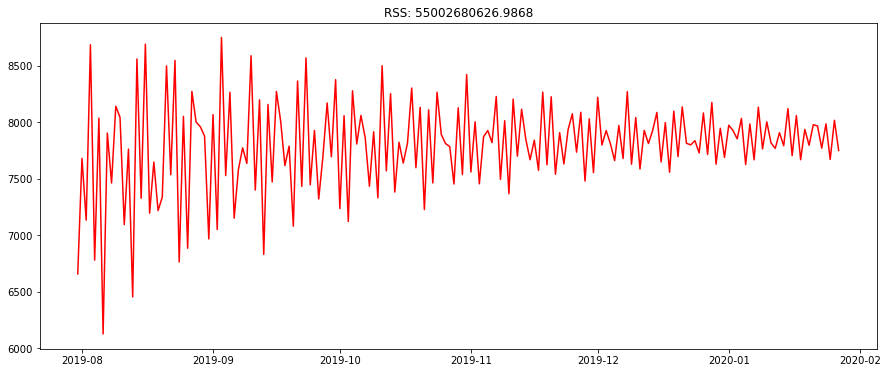

In [18]:
model = ARIMA(ts, order=(8, 0, 8)) 
results_ARIMA = model.fit(disp=2) 

predicted = results_ARIMA.predict(start=len(ts), end=len(ts) + 180, exog=None, typ='linear', dynamic=False)
rangeDates = np.array([ts[:-2:-1].keys()[0].date() + timedelta(x) for x in range(181)],dtype='datetime64[D]')
predicted = pd.Series(predicted.values,rangeDates)

#plt.plot(ts)
plt.plot(predicted, color='red') 
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts)**2))

C:\Users\AlexandredeBarrosRod\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


Text(0.5, 1.0, 'RSS: 55002680626.9868')

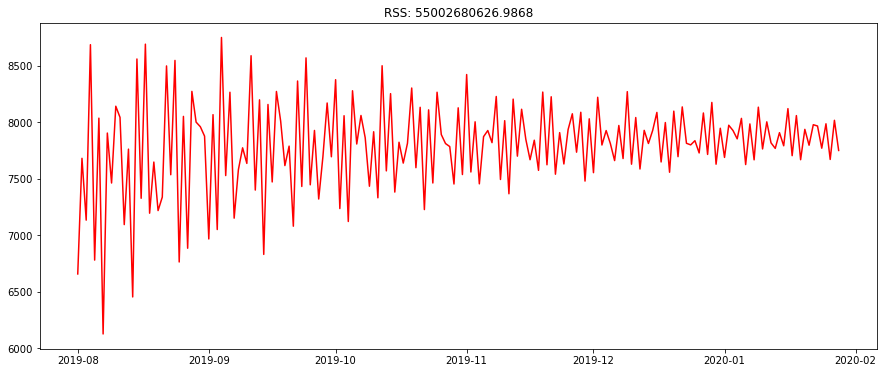

In [19]:
nsteps = 181
forecast = results_ARIMA.predict(start=len(ts), end=len(ts) + 180, exog=None, typ='linear', dynamic=False)
rangeDates = np.array([ts[:-2:-1].keys()[0].date() + timedelta(x + 1) for x in range(nsteps)],dtype='datetime64[D]')
forecast = pd.Series(forecast.values,rangeDates)

plt.plot(ts[len(ts):])
plt.plot(forecast, color='red') 
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts)**2))

Text(0.5, 1.0, 'RSS: 55002680626.9868')

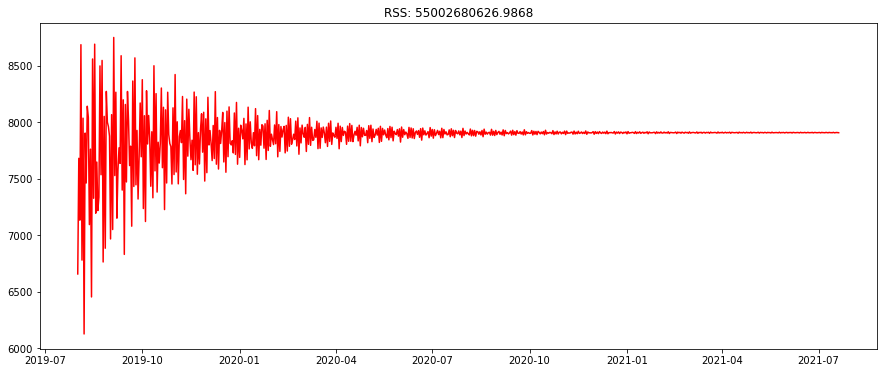

In [20]:
nsteps = 720
forecast, stderr, conf_int = results_ARIMA.forecast(steps=nsteps)
rangeDates = np.array([ts[:-2:-1].keys()[0].date() + timedelta(x + 1) for x in range(nsteps)],dtype='datetime64[D]')
forecast = pd.Series(forecast,rangeDates)

#plt.plot(ts)
plt.plot(forecast, color='red') 
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts)**2))

C:\Users\AlexandredeBarrosRod\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\AlexandredeBarrosRod\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but 

C:\Users\AlexandredeBarrosRod\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\AlexandredeBarrosRod\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\AlexandredeBarrosRod\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\AlexandredeBarrosRod\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\AlexandredeBarrosRod\Anaconda3\lib\site-pac

C:\Users\AlexandredeBarrosRod\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\AlexandredeBarrosRod\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\AlexandredeBarrosRod\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\AlexandredeBarrosRod\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\AlexandredeBarrosRod\Anaconda3\lib\site-pac

C:\Users\AlexandredeBarrosRod\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\AlexandredeBarrosRod\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\AlexandredeBarrosRod\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\AlexandredeBarrosRod\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\AlexandredeBarrosRod\Anaconda3\lib\site-pac

C:\Users\AlexandredeBarrosRod\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\AlexandredeBarrosRod\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\AlexandredeBarrosRod\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\AlexandredeBarrosRod\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\AlexandredeBarrosRod\Anaconda3\lib\site-pac

495    6656.969372
496    7680.033058
497    7132.969440
498    8685.355660
499    6779.438229
          ...     
670    7965.822122
671    7769.586081
672    7985.539155
673    7670.055635
674    8016.324916
Length: 180, dtype: float64


Text(0.5, 1.0, 'RSS: 55002680626.9868')

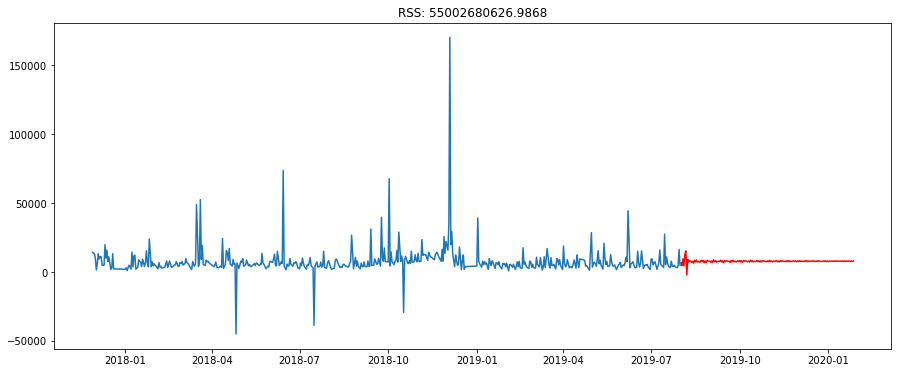

In [34]:
nsteps = 180
forecast = ts
newDate = ts[:-2:-1].keys()[0].date()
modelX = ARIMA(forecast, order=(8, 0, 8)) 
results_ARIMAX = modelX.fit(disp=-1) 

for i in np.arange(nsteps):
    newDate = newDate + timedelta(days=1)
    idx = len(forecast) - len(ts) + 1
    
    predicted = results_ARIMAX.predict(start=len(ts), end=len(ts) + i, exog=None, typ='linear', dynamic=False)
    #print(predicted)
    forecast = forecast.append(pd.Series(index=[newDate], data=predicted[:-2:-1].values))

print(predicted)
#print(forecast[len(ts):len(ts) + 10])
plt.plot(forecast[len(ts):], color='red') 
plt.plot(ts)
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts)**2))

In [ ]:
modelX = ARIMA(forecast, order=(8, 0, 8)) 
results_ARIMAX = modelX.fit(disp=-1) 

invoice_date
2017-11-28    14450.54
2017-11-29    13411.96
2017-11-30    13290.25
2017-12-01     9687.28
2017-12-02     1443.26
                ...   
2019-07-26     3631.94
2019-07-28     3150.26
2019-07-29     4374.54
2019-07-30    16374.76
2019-07-31     4964.93
Name: price, Length: 495, dtype: float64


Text(0.5, 1.0, 'RSS: 55002680626.9868')

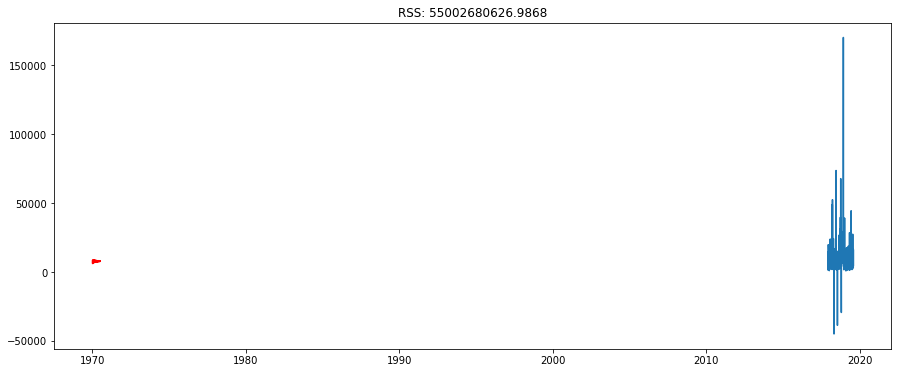

In [33]:
nsteps = 180
forecast = ts
newDate = ts[:-2:-1].keys()[0].date()

predicted, stderr, conf_int = results_ARIMAX.forecast(steps=nsteps)

plt.plot(predicted, color='red') 
print(forecast)
plt.plot(ts)
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts)**2))